<a href="https://colab.research.google.com/github/4jVb/friday-for-2morrow/blob/main/cookbook/tutorials/3_gfp_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Tutorial 3](https://github.com/evolutionaryscale/esm/tree/main/cookbook/tutorials): Design a GFP Candidate with ESM3
Hola
This notebook walks through the computational methods used to design esmGFP in [Hayes et al., 2024](https://doi.org/10.1101/2024.07.01.600583). esmGFP has similar brightness and spectral properties as GFPs found in nature despite being a far distance (58% identity) from known fluorescent proteins, but we also found many other bright new GFPs with similar or higher sequence identity. One can likely design a lot more new GFPs with the approach sketched in this notebook!

This notebook implements the core prompt used to begin the chain of thought used to create esmGFP. The overall process we used differs in two keys ways:

1. We continued the generation process beyond what is shown in this notebook
   to do a joint optimization of the generated sequence and structure.
2. We used significantly more compute than is easy to do with a notebook to
   generate many designs and filter them with a set of computational filters and
   ranking mechanisms.

And we validated a small number of the generated designs in a wet lab, which of course you can also do... but this notebook isn't very helpful with that!


## Set up the notebook and model (via the Forge API).

We begin by installing the [esm package](https://github.com/evolutionaryscale/esm) and py3Dmol, which will allow us to visualize our generations, and then importing necessary packages.


In [ ]:
from IPython.display import clear_output

!pip install git+https://github.com/evolutionaryscale/esm.git
!pip install py3Dmol

clear_output()  # Suppress pip install log lines after installation is complete.

In [ ]:
from getpass import getpass

import biotite.sequence as seq
import biotite.sequence.align as align
import biotite.sequence.graphics as graphics
import matplotlib.pyplot as pl
import py3Dmol
import torch
from esm.sdk import client
from esm.sdk.api import ESMProtein, GenerationConfig
from esm.utils.structure.protein_chain import ProteinChain

ESM3 is a frontier generative model for biology. It is scalable due to its ability to tokenize sequence, structure, and function and use a (nearly standard) transformer architecture while still being able to reason across all modalities simulateously.

The largest ESM3 (98 billion parameters) was trained with 1.07e24 FLOPs on 2.78 billion proteins and 771 billion unique tokens. To create esmGFP we used the 7 billion parameter variant of ESM3. We'll use this model via the [EvolutionaryScale Forge](https://forge.evolutionaryscale.ai) API.

Grab a token from [the Forge console](https://forge.evolutionaryscale.ai/console) and add it below. Note that your token is like a password for your account and you should take care to protect it. For this reason it is recommended to frequently create a new token and delete old, unused ones. It is also recommended to paste the token directly into an environment variable or use a utility like `getpass` as shown below so tokens are not accidentally shared or checked into code repositories.


In [ ]:
token = getpass("Token from Forge console: ")

Token from Forge console: ··········


We then create a model stub that behaves somewhat like a PyTorch model, but under the hood it sends the inputs to the Forge server, runs the inputs through the neural network weights on that remote server, and then returns the output tensors here in this notebook. This stub can also be used in the EvolutionaryScale SDK to simplify a lot of the operations around generation, folding, and generally using the sampling. This is important because iterative sampling is key to getting the best performance from ESM3, and the SDK manages a lot of the complexity around implementing these standard routines.


In [ ]:
model = client(
    model="esm3-medium-2024-03", url="https://forge.evolutionaryscale.ai", token=token
)

## Construct the GFP Prompt


ESM3 is a generative model. To access the generative capabilities we need to get comfortable with constructing prompts. ESM3 jointly reasons across sequence, structure, and function of proteins, so we can construct new types of prompts that can guide the model to generate proteins with higher levels of control than many other biological language models.

Sequence, structure, and function modalities are represented as tracks of discrete tokens that are present at both the input and output of the model and fused into a single latent space within the model. ESM3 is trained
with a generative masked language modeling objective with variable mask rates, so we can prompt with a fully or partially masked context and different points of conditioning across the various tracks. This gives us an opportunity to be highly creative with how we specify our prompts!

Prompt engineering is a bit of an art and a bit of a science, so one typically needs to experiment to get a prompt that produces a desired result. Also because we use sampling to generate from the model the results of different generations from the same prompt will vary. Some prompts tend to have higher success rates requiring only a few generations to get a candidate protein design. Other more difficult prompts may require thousands of generations! The models are more controllable with alignment.

The model we will be using is the raw pretrained (unaligned) model, but we've worked a lot on this prompt so one can typically get an interesting design with only a few generations.


We'll construct our prompt from fragments of the [1qy3](https://www.rcsb.org/structure/1qy3) sequence and structure from the PDB. The following code fetches data from the PDB and then uses ESM3's tokenizers to convert the sequence and structure to tokens that can be passed into the model. Once can see that both the amino acid type and the coordinates are converted into one discrete token per sequence position.


In [ ]:
template_gfp = ESMProtein.from_protein_chain(
    ProteinChain.from_rcsb("1qy3", chain_id="A")
)
template_gfp_tokens = model.encode(template_gfp)

print("Sequence tokens:")
print(
    "    ", ", ".join([str(token) for token in template_gfp_tokens.sequence.tolist()])
)

print("Structure tokens:")
print(
    "    ", ", ".join([str(token) for token in template_gfp_tokens.structure.tolist()])
)

Sequence tokens:
     0, 15, 6, 9, 9, 4, 18, 11, 6, 7, 7, 14, 12, 4, 7, 9, 4, 13, 6, 13, 7, 17, 6, 21, 15, 18, 8, 7, 8, 6, 9, 6, 9, 6, 13, 5, 11, 19, 6, 15, 4, 11, 4, 15, 18, 12, 23, 11, 11, 6, 15, 4, 14, 7, 14, 22, 14, 11, 4, 7, 11, 11, 4, 11, 19, 6, 7, 16, 23, 18, 8, 10, 19, 14, 13, 21, 20, 15, 16, 21, 13, 18, 18, 15, 8, 5, 20, 14, 9, 6, 19, 7, 16, 9, 5, 11, 12, 8, 18, 15, 13, 13, 6, 17, 19, 15, 11, 10, 5, 9, 7, 15, 18, 9, 6, 13, 11, 4, 7, 17, 10, 12, 9, 4, 15, 6, 12, 13, 18, 15, 9, 13, 6, 17, 12, 4, 6, 21, 15, 4, 9, 19, 17, 19, 17, 8, 21, 17, 7, 19, 12, 11, 5, 13, 15, 16, 15, 17, 6, 12, 15, 5, 17, 18, 15, 12, 10, 21, 17, 12, 9, 13, 6, 8, 7, 16, 4, 5, 13, 21, 19, 16, 16, 17, 11, 14, 12, 6, 13, 6, 14, 7, 4, 4, 14, 13, 17, 21, 19, 4, 8, 11, 16, 8, 5, 4, 8, 15, 13, 14, 17, 9, 15, 10, 13, 21, 20, 7, 4, 4, 9, 18, 7, 11, 5, 5, 6, 12, 2
Structure tokens:
     4098, 1025, 3124, 1129, 3227, 722, 1645, 2037, 2490, 60, 2567, 1779, 457, 2708, 383, 2219, 653, 4084, 2984, 3370, 66, 608, 2504, 103,

We'll now build a prompt. Specifically we'll specify 4 amino acid identities at positions near where we want the chromophore to form, and 2 amino acid identities on the beta barrel that are known to support chromophore formation.

Furthermore we'll specify the structure should be similar to the 1qy3 structure at all these positions by adding tokens from the encoded 1qy3 structure to the structure track of our prompt. We'll also specify a few more positions (along the alpha helix kink).


In [ ]:
prompt_sequence = ["_"] * len(template_gfp.sequence)
prompt_sequence[59] = "T"
prompt_sequence[62] = "T"
prompt_sequence[63] = "Y"
prompt_sequence[64] = "G"
prompt_sequence[93] = "R"
prompt_sequence[219] = "E"
prompt_sequence = "".join(prompt_sequence)

print(template_gfp.sequence)
print(prompt_sequence)

prompt = model.encode(ESMProtein(sequence=prompt_sequence))

# We construct an empty structure track like |<bos> <mask> ... <mask> <eos>|...
prompt.structure = torch.full_like(prompt.sequence, 4096)
prompt.structure[0] = 4098
prompt.structure[-1] = 4097
# ... and then we fill in structure tokens at key residues near the alpha helix
# kink and at the stabilizing R and E positions on the beta barrel.
prompt.structure[55:70] = template_gfp_tokens.structure[56:71]
prompt.structure[93] = template_gfp_tokens.structure[93]
prompt.structure[219] = template_gfp_tokens.structure[219]

print("".join(["✔" if st < 4096 else "_" for st in prompt.structure]))

KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQEATISFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGI
___________________________________________________________T__TYG____________________________R_____________________________________________________________________________________________________________________________E_______
_______________________________________________________✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔_______________________✔_____________________________________________________________________________________________________________________________✔_________


The output shows the original 1qy3 sequence and the our prompt sequence track amino acid identities and the positions that have a token on the structure track. ESM3 will then be tasked with filling in the structure and sequence at the remaining masked (underscore) positions.

One small note, we introduced the mutation A93R in our prompt. This isn't a mistake. Using Alanine at this position causes the chromophore to mature extremely slowly (which is how we are able to measure the precyclized structure of GFP!). However we don't want to wait around for our GFPs to glow so we go with Arginine at this position.


## Generate a Structure

We then prompt the model and decode the structure tokens track. This is similar to creating a backbone scaffold for an active site prompt, but there are some subtle differences. For example, since we've already specified some of the structure tokens (e.g., around the active site and key corresponding residues) the model literally generates around this structure.

Tokens are iteratively sampled from ESM3. They
can be sampled one at a time, or in parallel, in any order, until all positions are fully unmasked. The generate() function in the EvolutionaryScale SDK implements one recipe we think is effective for sampling from the model.


In [ ]:
%%time

num_tokens_to_decode = min((prompt.structure == 4096).sum().item(), 20)


structure_generation = model.generate(
    prompt,
    GenerationConfig(
        # Generate a structure.
        track="structure",
        # Sample one token per forward pass of the model.
        num_steps=num_tokens_to_decode,
        # Sampling temperature trades perplexity with diversity.
        temperature=1.0,
    ),
)

print("These are the structure tokens corresponding to our new design:")
print(
    "    ", ", ".join([str(token) for token in structure_generation.structure.tolist()])
)

# Decodes structure tokens to backbone coordinates.
structure_generation_protein = model.decode(structure_generation)

These are the structure tokens corresponding to our new design:
     4098, 2552, 779, 1067, 936, 3950, 3012, 760, 2490, 3509, 2068, 3821, 3881, 1726, 35, 3332, 3295, 1763, 2458, 2269, 473, 3254, 957, 163, 3239, 2721, 3054, 3889, 3376, 3744, 2189, 2117, 239, 3588, 2181, 3938, 2010, 3213, 3068, 276, 836, 2302, 295, 2557, 2149, 1962, 965, 533, 2723, 1531, 1818, 376, 3419, 1417, 657, 1774, 732, 1797, 3372, 3403, 2370, 2582, 3704, 2737, 3007, 1660, 499, 484, 2202, 2786, 2630, 2647, 3051, 1561, 1411, 3909, 499, 531, 2248, 1853, 2824, 2163, 1760, 2250, 463, 2423, 1821, 288, 934, 3558, 3881, 1071, 2620, 1066, 2984, 490, 2361, 2875, 597, 959, 728, 349, 3080, 3041, 708, 3362, 2633, 178, 3494, 784, 942, 481, 3188, 1302, 3254, 3514, 1985, 971, 1286, 1880, 1293, 1346, 3968, 2885, 4051, 2464, 739, 2612, 592, 1792, 3489, 33, 3208, 2196, 2688, 2301, 1265, 1525, 895, 1340, 2403, 3038, 3537, 2271, 313, 378, 1879, 2540, 3264, 1587, 1605, 830, 3562, 379, 762, 2711, 821, 4086, 90, 2557, 3670, 557, 712, 57,

Now let's visualize our generated structure. This will probably look like the familiar GFP beta barrel around an alpha helix.


In [ ]:
view = py3Dmol.view(width=1000, height=500)
view.addModel(
    structure_generation_protein.to_protein_chain().infer_oxygen().to_pdb_string(),
    "pdb",
)
view.setStyle({"cartoon": {"color": "lightgreen"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

At this point we only want to continue the generation if this design is a close match to a wildtype GFP at the active site, has some structural difference across the full protein (otherwise it would end up being very sequence-similar to wildtype GFP), and overall still looks like the classic GFP alpha helix in a beta barrel structure.

Of course when generating many designs we cannot look at each one manually, so we adopt some automated rejection sampling criteria based on the overall structure RMSD and the constrained site RMSD for our generated structure being faithful to the prompt. If these checks pass then we'll try to design a sequence for this structure. If not, one should go back up a few cells and design another structure until it passes these computational screens. (Or not... this is your GFP design!)


In [ ]:
constrained_site_positions = [59, 62, 63, 64, 93, 219]

template_chain = template_gfp.to_protein_chain()
generation_chain = structure_generation_protein.to_protein_chain()

constrained_site_rmsd = template_chain[constrained_site_positions].rmsd(
    generation_chain[constrained_site_positions]
)
backbone_rmsd = template_chain.rmsd(generation_chain)

c_pass = "✅" if constrained_site_rmsd < 1.5 else "❌"
b_pass = "✅" if backbone_rmsd > 1.5 else "❌"

print(f"Constrained site RMSD: {constrained_site_rmsd:.2f} Ang {c_pass}")
print(f"Backbone RMSD: {backbone_rmsd:.2f} Ang {b_pass}")

Constrained site RMSD: 2.05 Ang ❌
Backbone RMSD: 2.19 Ang ✅


# Sequence Design

Now we have a backbone with some structural variation but that also matches the GFP constrained site, and we want to design a sequence that folds to this structure. We can use the prior generation, which is exactly our original prompt plus the new structure tokens representing the backbone, to prompt ESM3 again.

One we have designed a sequence we'll want to confirm that sequence is a match for our structure, so we'll remove all other conditioning from the prompt and fold the sequence. Conveniently with ESM3, folding a sequence is simply generating a set of structure tokens conditioned on the amino acid sequence. In this case we want the model's highest confidence generation (with no diversity) so we sample with a temperature of zero.


In [ ]:
%%time

# Based on internal research, there's not a benefit to iterative decoding past 20 steps
num_tokens_to_decode = min((prompt.sequence == 32).sum().item(), 20)

sequence_generation = model.generate(
    # Generate a sequence.
    structure_generation,
    GenerationConfig(track="sequence", num_steps=num_tokens_to_decode, temperature=1.0),
)

# Refold
sequence_generation.structure = None
length_of_sequence = sequence_generation.sequence.numel() - 2
sequence_generation = model.generate(
    sequence_generation,
    GenerationConfig(track="structure", num_steps=1, temperature=0.0),
)

# Decode to AA string and coordinates.
sequence_generation_protein = model.decode(sequence_generation)

CPU times: user 62.7 ms, sys: 8.47 ms, total: 71.2 ms
Wall time: 13.2 s


We now have a candidate GFP sequence!


In [ ]:
sequence_generation_protein.sequence

'MSKGEELFTGVVPILVELDGDVNGHKISGTEGEGDATNGKLTLKFICTTGKLPVPRLTTTTTTYGQCFTRYPDHMKRHHDFFKSAMPEGYVQERTISFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNRGSHNVYIMADKQKNGIKANFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGI'

We can align this sequence against the original template to see how similar it is to avGFP. One might also want to search against all known fluorescent proteins to assess the novelty of this potential GFP.


Sequence identity: 92.14%

Sequence alignment:


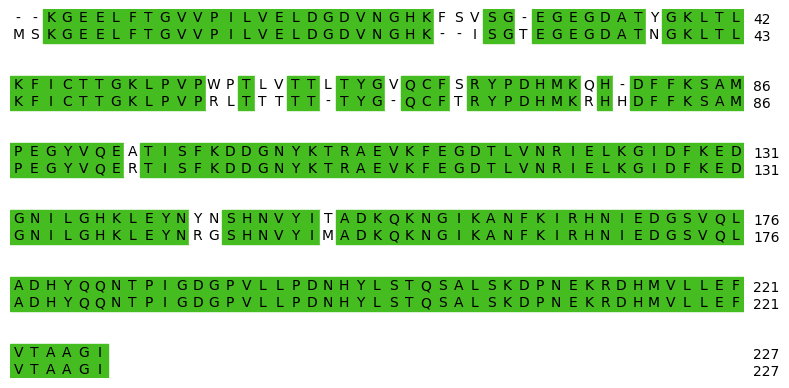

In [ ]:
seq1 = seq.ProteinSequence(template_gfp.sequence)
seq2 = seq.ProteinSequence(sequence_generation_protein.sequence)

alignments = align.align_optimal(
    seq1, seq2, align.SubstitutionMatrix.std_protein_matrix(), gap_penalty=(-10, -1)
)

alignment = alignments[0]

identity = align.get_sequence_identity(alignment)
print(f"Sequence identity: {100*identity:.2f}%")

print("\nSequence alignment:")
fig = pl.figure(figsize=(8.0, 4.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax, alignment, symbols_per_line=45, spacing=2, show_numbers=True
)
fig.tight_layout()
pl.show()

We now recheck our computational metrics for the constrained site. If we see the constrained site is not a match then we'd want to try designing the sequence again. If many attempts to design a sequence that matches the structure fail, then it's likely the structure is not easily designable and we may want to reject this structure generation as well!

At this point the backbone RMSD doesn't matter very much to us, so long as the sequence is adequately distant to satisfy our scientific curiosity!


In [ ]:
template_chain = template_gfp.to_protein_chain()
generation_chain = sequence_generation_protein.to_protein_chain()

constrained_site_rmsd = template_chain[constrained_site_positions].rmsd(
    generation_chain[constrained_site_positions]
)
backbone_rmsd = template_chain.rmsd(generation_chain)

c_pass = "✅" if constrained_site_rmsd < 1.5 else "❌"
b_pass = "🤷‍♂️"

print(f"Constrained site RMSD: {constrained_site_rmsd:.2f} Ang {c_pass}")
print(f"Backbone RMSD: {backbone_rmsd:.2f} Ang {b_pass}")

Constrained site RMSD: 1.82 Ang ❌
Backbone RMSD: 1.63 Ang 🤷‍♂️


An now we can visualize the final structure prediction of our candidate GFP design.


In [ ]:
view = py3Dmol.view(width=600, height=600)
view.addModel(sequence_generation_protein.to_pdb_string(), "pdb")
view.setStyle({"cartoon": {"color": "lightgreen"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Before considering this sequence for wet lab validation, we run a joint optimization of the sequence and structure. The outputs of that process are then passed through stringent computational filters and then many designs from many starting points are ranked by a number of computational scores to select the final designs sent for testing. We'll walk through that process in a different notebook.


If you've made it this far it's worth noting that this isn't the only method to prompt ESM3 to design a GFP, it's just the one we used to report the successful generation of esmGFP in our paper. We hope you'll try different techniques to generate from ESM3. We're interested to hear what works for you!
